# 1 Parse the wave format And generate MFCC Features

##1.1 parse wave format
>Most of the data we've aquired are of wave format, so wave module in python to will be used to parse the speech files.
####wave format structure
channels: number of channels of the wave file, we will only use one channel of the data(some data only have one channel) <br />
nframe: number of frames<br />
framerate: sample rate of the audio <br />
sampwidth: number of bytes of one frame <br />



In [1]:
import wave
import struct
import numpy as np
def wave2signal(wave, nframes, samplewidth):
    # Only support 8bit, 16bit, 32bit decoding
    codecs = {1: 'b', 2: 'h', 4:'i'}
    code = codecs[samplewidth]
    return np.array(struct.unpack(nframes * code, wave))/pow(2, 8*samplewidth - 1)
                                  
def wave_parse(infile):
    """parse the wave file, get the params and frame data, 
    only support one channel current now"""
    wav = wave.Wave_read(infile)
    params = wav.getparams()
    frames = wav.readframes(params.nframes)
    wav.close()
    signal = wave2signal(frames, params.nframes, params.sampwidth)
    return (params.framerate, signal)




####Test wave_parse

framerate:  16000
signal:  [-0.00061035  0.00106812 -0.00933838 -0.01501465 -0.01330566]
signal length:  76000


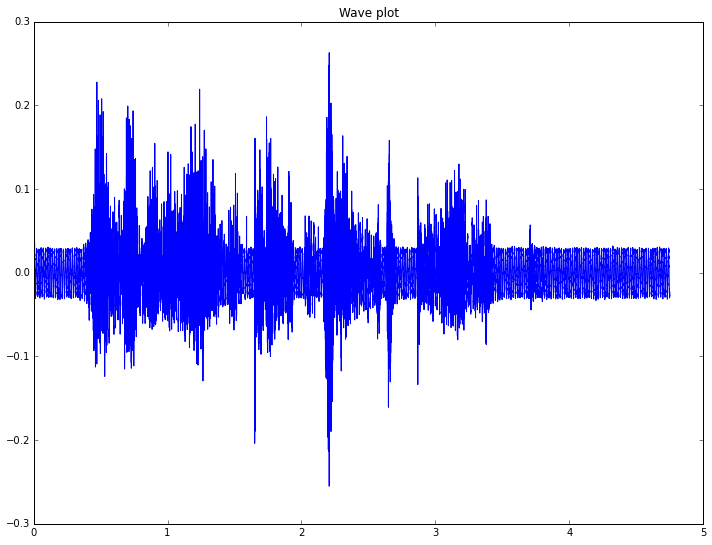

In [2]:
import scipy
import pylab
import matplotlib
import matplotlib.pyplot as plt

#matplotlib.style.use('ggplot')
%matplotlib inline

(framerate, signal) = wave_parse("/AIP/2old2play-20110606-wlt/wav/a0233.wav")
print("framerate: ", framerate)
print("signal: ",signal[0:5])
print("signal length: ", len(signal))

time = np.array(range(0, len(signal)))/framerate

plt.figure(figsize=(12,9))
plt.plot(time, signal)
plt.title("Wave plot")
plt.show()




## Add preprocessing processes
#### FIXME downsampling and something else ^_^
The frame rate of the wave files may not be all the same, so we need to do some downsampling or oversampling processes.
In this project, 16K Hz frame rate and 16bit sample width will be used

In [3]:
class SignalPreprecess(object):
    def __init__(self, framerate):
        self.framerate = framerate
    def downsample(self):
        return 0
    

## 1.2 Feature generation
### MFCC
In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.<br />
MFCC stands for Mel Frequency cepstral coeffients, it is a widely used feature extraction method for speech recognition and many other applications for signal processing.
### Steps of MFCC
>+ Preemphasis
+ Frame the signal into short frames
+ For each frame calculate the periodogram estimate of the power spectrum
+ Apply the Mel filterbank to the power spectra, sum the energy in each filter
+ Take the logarithm of all filterbank energies
+ Take the DCT of the log filterbank energies
+ Keep DCT coefficients 2-13, discard the rest, and Delta and Delta-Delta features are usually also appended


### Explanation of MFCC steps
An audio signal is constantly changing, so to simplify things we assume that **on short time scales the audio signal doesn't change much(statitiscally stationary)**. This is why we frame the signal into 20-40ms frames.
+ Preemphasis
>preemphasis will emphasis the high frequency part of the sound, and make the spectrum more flatten.<br />
$$\begin{aligned} H(Z) = 1 - \mu z^{-1} \end{aligned}$$
+ Frame
>Frame the signal into 20-40ms frames, 25ms is standard(sometimes 25.6ms). This means the frame length of a 16kHz signal is 
16000 * 0.025 = 400 samples. Frame step is usally something like 10ms(160 samples), which allows some overlop to the frames. So the first 400 sample frame starts from sample 0, the next 400 sample frame starts from 160 etc. until the end of the speech is reached. If the speech file does not divide into an even number of frames, pad it with zeros so that it does.
+ Short Time Fourier Transform 
> The Discrete Fourier Transform of the frame, perform the following: <br />
$$\begin{aligned} S_{i}(k) = \sum_{n=1}^{N} s_{i}(n) h(n) e^{-j 2 \pi kn/N}  \ \ \ \ \ 1 \leq k \leq K  \end{aligned}$$
where h(n) is an N sample long analysis window(hamming window), and K is the length of the DFT <br />
The periodogram-based power spectral estimate (also known as **Periodogram estimate for the spectrum**) for the speech frame $s_{i}(n)$ is given by
$$\begin{aligned} P_{i}(k) = \frac{1}{N} |S_{i}(k)|^{2} \end{aligned}$$
+ Log energies
> This will calculate the logarithm of the power spectrum
$$ L_{i}(k) = lg(P_{i}(k))$$
+ Trianglar Bandpass Filters
> We multiply the magnitue frequency response by a set of 20-40(26 for standard) triangular bandpass filters to get the log energy of each triangular bandpass filter
In this step we will use **Mel** to **Hz** and **Hz** to **Mel** scale transforms.<br />
And then construct the triangular bandpass filters <br />
The respone frequency of the filters are defined as:
$$\begin{aligned} H_{m}(k) =  \end{aligned}$$





In [185]:
import numpy as np
import scipy

def hz2mel(f):
    """mel scale"""
    return 2595.0 * np.log10(1.0 + f / 700.0)

def mel2hz(m):
    """inverse mel scala"""
    return 700.0 * (np.power(10.,  m / 2595.) - 1.)

def preemphasis(signal, alpha=0.97):
    """emphasis the high frequency part to make the spectrum more flatten"""
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])


def enframe(signal, frame_len, frame_step, window_func=lambda x: np.ones((1,x))):
    """frame the signal, may specify a analysis window function"""
    #FIXME add the frame length and frame step check
    # N: number samples; n: frame length; s: frame step; nf: number of frames
    N = len(signal)
    n = int(round(frame_len))
    s = int(round(frame_step))
    nf = int(np.ceil((N-n)/s)) + 1
    # pad the signal with zeros
    pad = np.zeros( s * (nf-1) + n - N)
    sigpad = np.append(signal, pad)
    win = np.tile(window_func(n),(nf,1))
    index1 = np.array(range(0, nf)) * np.tile(s, nf)
    index2 = index1 + np.tile(n-1, nf) + 1
    mp = map(lambda x,y: range(x, y), index1, index2)
    index = [x for x in mp]
    frames = sigpad[index] * win
    return frames

def stft(frames, nfft=512):
    """short time Fourier transform, rfft is for real input, 
    faster than fft with complex input"""
    return np.fft.rfft(frames, nfft)

def specpower(sigfft, nfft=512):
    """using the result of stft to calculate the power"""
    mag = np.absolute(sigfft) # Magnitude spectrum computation
    return 1. / nfft * np.square(mag) 

def logspecpower(specpow, threshold='y'):
    """log10 of spectrum power"""
    #FIXME
    pth = max(specpow) * 1e-20
    logspec = np.log10(np.max(specpow, pth))
    return logspec

def meltrifilter(n=26, nfft=512, framerate=16000, lower=300, upper=8000):
    """Compute Mel-spaced filterbank"""
    mlow = hz2mel(lower)
    mup  = hz2mel(upper)
    mstep = (mup - mlow) / (n + 1)
    # num of points = num of triangulars/filters + 2
    N = n + 2
    mel = np.array(range(0, N)) * mstep + mlow
    f = mel2hz(M)
    bin = np.floor((nfft + 1) * H / framerate)
    fbank = np.zeros([n,nfft/2+1])
    # using bins of fft 
    for j in range(0, n):
        for i in range(int(bin[j]),int(bin[j+1])):
            fbank[j,i] = (i - bin[j])/(bin[j+1]-bin[j])
        for i in range(int(bin[j+1]),int(bin[j+2])):
            fbank[j,i] = (bin[j+2]-i)/(bin[j+2]-bin[j+1])
    return (mel, f, fbank)

def bankenergy(specpow, fbank):
    return np.dot(specpow, fbank.T)

def DCT(logbankE):
    """using dct to get final ceptral coefficients"""
    return scipy.fftpack.dct(logbankE)

def mfcc_compute(signal, wlen=0.0250,step=0.010, alpha=0.97, samplerate=16000,
                 nfft=512,nfilter=26, lower=300, upper=8000):
    """compute mfcc"""
    # window length: wlen=0.0250 seconds, the wlength will be the
    # sample rate times wlen
    frame_len = int(samplerate * wlen)
    frame_step = int(samplerate * step)
    sig = preemphasis(signal, alpha)
    frames = enframe(sig, frame_len, frame_step, window_func=lambda x: np.ones((1,x)))
    sigfft = stft(frames, nfft)
    specp = specpower(sigfft, nfft)
    (M,F,fbank) = meltrifilter(nfilter, nfft, samplerate, lower, upper)
    bankE = bankenergy(specp, fbank)
    coeff = DCT(np.log10(bankE))
    logE  = logspecpower(np.sum(specp, 1))
    return (logE, coeff)
    
    


###Test
Preemphasis and short time Fourier transform

orignal signal is  [ 0.00106812 -0.00933838 -0.01501465 -0.01330566 -0.01470947 -0.01425171
 -0.01620483 -0.01547241 -0.01278687]
emphasised signal is  [ -6.10351562e-04   1.66015625e-03  -1.03744507e-02  -5.95642090e-03
   1.25854492e-03  -1.80297852e-03   1.64794922e-05  -2.38067627e-03
   2.46276855e-04   2.22137451e-03]


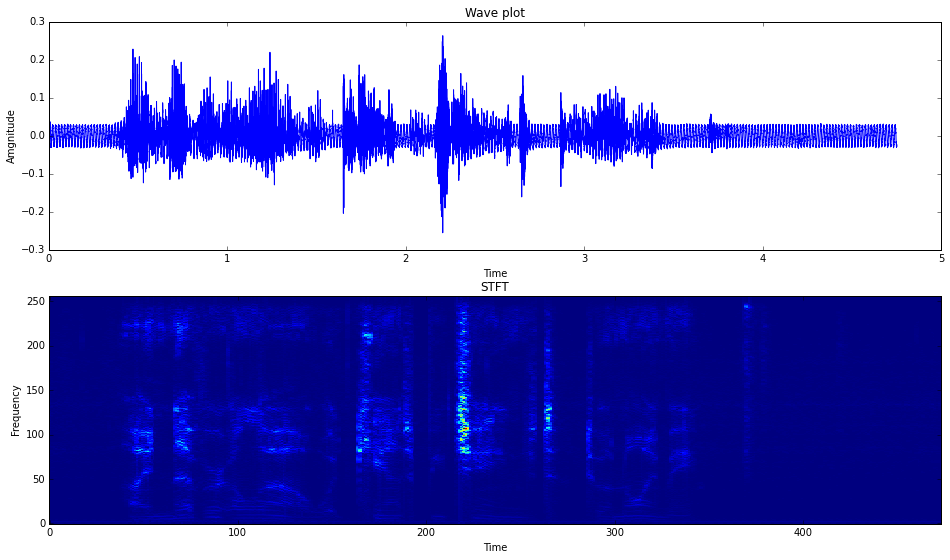

[[  9.91966328e-06   1.24600372e-05   8.41919188e-05 ...,   2.81046241e-09
    4.23159129e-09   7.05215098e-10]
 [  1.33760988e-05   1.54320554e-05   8.09904786e-05 ...,   9.50909085e-09
    2.97558311e-08   4.02263397e-08]
 [  1.84549700e-06   6.54870082e-06   8.36055154e-05 ...,   1.06177735e-08
    1.38667404e-08   1.82190095e-08]
 ..., 
 [  1.51093314e-05   1.69868133e-05   7.98235928e-05 ...,   1.08045141e-09
    5.01462197e-09   1.58374971e-08]
 [  1.25533672e-05   1.63817586e-05   8.05838227e-05 ...,   6.90870934e-10
    1.49389672e-09   4.37576273e-10]
 [  5.84008178e-06   1.16698344e-05   7.01624511e-05 ...,   2.73802889e-08
    2.04979994e-08   1.22010715e-08]]


In [164]:
import matplotlib
import matplotlib.pyplot as plt

#matplotlib.style.use('ggplot')
%matplotlib inline
sig = preemphasis(signal)
print("orignal signal is ", signal[1:10])
print("emphasised signal is ",sig[0:10])

frames = enframe(sig, 400, 160)
stftout = stft(frames, 512)
specp = specpower(stftout, 512)
#plot stft

# Plot the magnitude spectrogram.
plt.figure(figsize=(16,9))
plt.subplot(2,1,1)
plt.plot(time, signal)
plt.xlabel('Time')
plt.ylabel('Amgnitude')
plt.title("Wave plot")

plt.subplot(2,1,2)
plt.imshow(np.absolute(stftout.T), origin='lower', aspect='auto',
                interpolation='nearest')

plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title("STFT")
plt.show()


###Mel Frequency Test

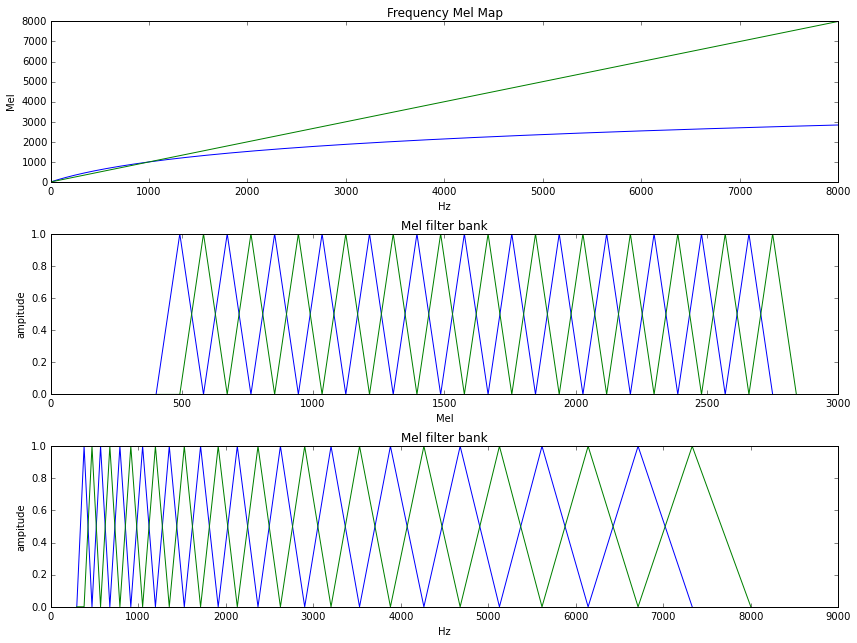

[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.0952381   0.04761905  0.        ]]


In [82]:
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.style.use('ggplot')
%matplotlib inline

hz = np.array(range(0, 8000))
mel = hz2mel(hz)
fs = 16000
filternum = 20

hz2 = mel2hz(mel)
(M, H, FB) = meltrifilter()
index = range(0, 26+2)
 
y1 = np.array([ x % 2 for x in range(0, 26+2)])
y2 = np.append([0], y1[0:-1])


plt.figure(figsize=(12,9))
plt.subplot(3,1,1)
plt.plot(hz, mel)
plt.plot(hz, hz)
plt.xlabel('Hz')
plt.ylabel('Mel')
plt.title("Frequency Mel Map")

# plot mel filter banks
plt.subplot(3,1,2)
plt.plot(M[:-1],y1[:-1])
plt.plot(M, y2)
plt.xlabel('Mel')
plt.ylabel('ampitude')
plt.title("Mel filter bank")

plt.subplot(3,1,3)
plt.plot(H[:-1],y1[:-1])
plt.plot(H, y2)
plt.xlabel('Hz')
plt.ylabel('ampitude')
plt.title("Mel filter bank")
plt.tight_layout()
plt.show()
print(FB)

###Test code 

In [186]:
N = len(sig)
n = 400
s = 160
nf = int(np.ceil((N-n)/s)) + 1
padsize = s * (nf-1) + n -N
zeros = np.zeros(padsize)

print(nf, padsize)
zeros
sigpad = np.append(sig, zeros)
#np.concatenate((sig,zeros))
window_func=lambda x: np.ones((1,x))
 

win = np.tile(window_func(n),(nf,1))
win.shape
index1 = np.array(range(0, nf)) * np.tile(s, nf)
index2 = index1 + np.tile(n-1, nf) +1
mp = map(lambda x,y: range(x, y), index1, index2)
index = [x for x in mp]
frames = sigpad[index] * win
frames.shape

s = np.fft.rfft(frames, 512)
np.square(np.absolute(s))
framerate
specp 
(M, H, fb) = meltrifilter()
print(H)
print(M)
print(fb)
bankE = np.dot(specp, fb.T)
D = DCT(np.log10(bankE))
np.sum(specp,1).shape

(E,  F) = mfcc_compute(signal)
print("specp: ", specp)
print("C: ", F)
print("bankE", bankE)

D[:,0:13]

474 80
[  300.           383.42040146   473.7997663    571.71861405   677.80589138
   792.74301197   917.26823331  1052.18139861  1198.34907431  1356.71011621
  1528.28169979  1714.16585376  1915.55653848  2133.74731496  2370.13965362
  2626.25193607  2903.72920794  3204.35374523  3530.0565021   3882.92951372
  4265.23933362  4679.44159219  5128.19676945  5614.38728376  6141.13600596
  6711.82631804  7330.12384505  8000.        ]
[  401.97058616   492.26882544   582.56706472   672.865304     763.16354328
   853.46178256   943.76002184  1034.05826112  1124.3565004   1214.65473968
  1304.95297896  1395.25121824  1485.54945752  1575.8476968   1666.14593608
  1756.44417535  1846.74241463  1937.04065391  2027.33889319  2117.63713247
  2207.93537175  2298.23361103  2388.53185031  2478.83008959  2569.12832887
  2659.42656815  2749.72480743  2840.02304671]
[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0. 

array([[-250.79178278,  -19.36659862,   -6.43072143, ...,   -0.64090667,
           2.66215447,    0.80051   ],
       [-267.63641274,  -25.513073  ,  -10.63205718, ...,   -0.37074015,
           3.70772794,   -1.82944132],
       [-266.66668708,  -20.69016432,   -8.56173266, ...,    2.0421872 ,
           5.48890316,   -2.17334014],
       ..., 
       [-272.52989763,  -22.12090458,   -8.0620979 , ...,   -0.44702466,
           1.25621169,   -0.67543474],
       [-272.42076599,  -21.20964152,   -8.12892848, ...,   -0.65478969,
           1.99518922,   -1.58527036],
       [-277.38662258,  -19.66118285,   -5.39368737, ...,   -0.60941656,
           2.52497988,   -2.15570281]])

In [8]:
a = np.zeros((1, 5))
print(a[0:4])
np.array(range(0,10)) * np.tile(160, 10)
index2
ind = np.array([1, 2, 3,4])

[[ 0.  0.  0.  0.  0.]]


In [101]:
i = range(index1[0], index2[0])
sigpad[i]
np.linspace(1,2,11)
hz2mel(300)
np.array(range(1, 3+1))
max([1,2], [2, 1])
3 %2

a = np.array([x % 2 for x in range(0, 26+2)])
a
b = np.append([0], a[0:-1])
b
np.finfo(float).eps
import scipy
scipy.fftpack.dct

<function scipy.fftpack.realtransforms.dct>

#References
http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
